
# Machine Learning Project Proposal #

## Exploring Used Car Auction: *Prices and Predicting the Possible End Price*

### Simon Coessens, Rana Islek

### April 2024



### 1. Necessary Libraries

In [2]:
!pip install numpy==1.23.5
!pip install pandas==1.5.2
!pip install kaleido

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.stats import skew
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Set display options and styles
pd.set_option('display.max_columns', None)
%matplotlib inline
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.set_style("white", {'axes.facecolor':'#2B2B2B', 'figure.facecolor':'#2B2B2B'})
sns.set_palette("coolwarm")

# Customize the default Matplotlib settings
plt.style.use("Solarize_Light2")
plt.rcParams.update({
    'axes.edgecolor': 'white',
    'axes.labelcolor': 'white',
    'xtick.color': 'white',
    'ytick.color': 'white',
    'text.color': 'white',
    'figure.facecolor': '#2B2B2B',
    'axes.facecolor': '#2B2B2B',
    'grid.color': '#2B2B2B',  # Same as background to hide gridlines
    'savefig.facecolor': '#2B2B2B',
    'savefig.edgecolor': '#2B2B2B'
})

### 2. Import Data

In [5]:
dfcar = pd.read_csv('/content/drive/My Drive/ml-project/data/car_prices.csv', on_bad_lines='skip')
dfcar.head(2)

year make    model trim body transmission                vin state  \
0  2015  Kia  Sorento   LX  SUV    automatic  5xyktca69fg566472    ca   
1  2015  Kia  Sorento   LX  SUV    automatic  5xyktca69fg561319    ca   

   condition  odometer  color interior                   seller    mmr  \
0        5.0   16639.0  white    black  kia motors america, inc  20500   
1        5.0    9393.0  white    beige  kia motors america, inc  20800   

   sellingprice                                 saledate  
0         21500  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)  
1         21500  Tue Dec 16 2014 12:30:00 GMT-0800 (PST)

**Definition of Features:**

* Date: The year of production of the car.

* Make: The brand of the car.

* Model: The edition of the car of a specific brand.

* Trim: (Trim levels) Just different versions of the model.

* Body: The shape and model of a particular car make (brand).

* Transmission: The mechanism that moves the power from the engine to the wheels.

* VIN: Vehichle identification number.

* State: The state in which the car is auctioned.

* Condition: The condition of the cars being at the time of auction.

* Odometer (Mileage): The distance the car has travelled since manufactured.

* Color: Exterior color of the car.

* Interior: Interior color of the car.

* Seller: The seller of the car, car dealers.

* MMR: Manhiem Market Record, the market estimated price of the cars.

* Sellingprice: The price a car was sold at auctions.

* Saledate: The date on which the car has been sold.

### 3. Data Cleansing

In [6]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558811 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558811 non-null  int64  
 1   make          548510 non-null  object 
 2   model         548412 non-null  object 
 3   trim          548160 non-null  object 
 4   body          545616 non-null  object 
 5   transmission  493458 non-null  object 
 6   vin           558811 non-null  object 
 7   state         558811 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558717 non-null  float64
 10  color         558062 non-null  object 
 11  interior      558062 non-null  object 
 12  seller        558811 non-null  object 
 13  mmr           558811 non-null  int64  
 14  sellingprice  558811 non-null  int64  
 15  saledate      558811 non-null  object 
dtypes: float64(2), int64(3), object(11)
memory usage: 68.2+ MB


In [7]:
# Count the number of null values for each column
null_counts = dfcar.isnull().sum()

# Display the null counts
print(null_counts)


year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65353
vin                 0
state               0
condition       11794
odometer           94
color             749
interior          749
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64


As we can see, there are some columns that have null values; so before diving into analysis we need to handle them first.


In [8]:
# Numerical column describe
nums = dfcar.select_dtypes(exclude=['object'])
nums.describe(percentiles=(.25, .75, .90, .95, .98))

year      condition       odometer            mmr  \
count  558811.000000  547017.000000  558717.000000  558811.000000   
mean     2010.038696       3.424512   68323.195797   13769.324646   
std         3.966812       0.949439   53397.752933    9679.874607   
min      1982.000000       1.000000       1.000000      25.000000   
25%      2007.000000       2.700000   28374.000000    7100.000000   
50%      2012.000000       3.600000   52256.000000   12250.000000   
75%      2013.000000       4.200000   99112.000000   18300.000000   
90%      2014.000000       4.600000  142760.400000   25500.000000   
95%      2014.000000       4.800000  170059.000000   30600.000000   
98%      2014.000000       5.000000  202596.680000   38500.000000   
max      2015.000000       5.000000  999999.000000  182000.000000   

        sellingprice  
count  558811.000000  
mean    13611.262461  
std      9749.656919  
min         1.000000  
25%      6900.000000  
50%     12100.000000  
75%     18200.000000  
90%     25500.000000  
95%     30600.000000  
98%     38500.000000  
max    230000.000000

As we can see in the table above, there are some data which does not make sense such as 1 and 999999 in odometer, 25 in mmr, and 1 in sellingprice. So that, for the further process we would treat those unlogical values as "outliers".


In [9]:
# Non-numerical column describe
cats = dfcar.select_dtypes(include=['object'])
cats.describe()

make   model    trim    body transmission                vin  \
count   548510  548412  548160  545616       493458             558811   
unique      96     973    1975      86            2             550296   
top       Ford  Altima    Base   Sedan    automatic  wbanv13588cz57827   
freq     93554   19349   55817  199437       475914                  5   

         state   color interior              seller  \
count   558811  558062   558062              558811   
unique      38      20       17               14264   
top         fl   black    black  nissan-infiniti lt   
freq     82945  110970   244325               19693   

                                       saledate  
count                                    558811  
unique                                     3745  
top     Tue Feb 10 2015 01:30:00 GMT-0800 (PST)  
freq                                       5334

As we can see in the table above, "vin" has so many unique values since it is an identification number for each car but we need to point out the difference between the count and unique values. So that, for further data processing we should check possible duplicates or null values for "vin" column. Moreover, even though the other columns looks logical here, we still need to do check any duplicates, nulls, and their uniformity.



#### *3.1 Word Uniformity*

There is often a lack of uniformity in string values, so it is necessary put strings in an uniform before proceeding with analysis.



In [10]:
# Uppercase on each letter at the beginning of a word
dfcar['model'] = dfcar['model'].str.title()
dfcar['transmission'] = dfcar['transmission'].str.title()
dfcar['color'] = dfcar['color'].str.title()
dfcar['interior'] = dfcar['interior'].str.title()
dfcar['seller'] = dfcar['seller'].str.title()

# All uppercase
dfcar['make'] = dfcar['make'].str.upper()
dfcar['body'] = dfcar['body'].str.upper()
dfcar['trim'] = dfcar['trim'].str.upper()
dfcar['state'] = dfcar['state'].str.upper()

#### *3.2 Duplicate Checking*

In [11]:
# 1. Entire column
dfcar[dfcar.duplicated()]

Empty DataFrame
Columns: [year, make, model, trim, body, transmission, vin, state, condition, odometer, color, interior, seller, mmr, sellingprice, saledate]
Index: []

As we can see, no entire row duplicates in the dataframe which is good.

In [12]:
#2. Specific column
dfcar[dfcar.duplicated(['vin'], keep=False)]


year    make             model               trim         body  \
21      2014     BMW          5 Series               528I        SEDAN   
70      2014    AUDI                A8     L 3.0T QUATTRO        SEDAN   
382     2013     KIA              Soul               BASE        WAGON   
394     2013  NISSAN            Altima              2.5 S        COUPE   
432     2013     KIA               Rio                 LX        SEDAN   
...      ...     ...               ...                ...          ...   
558711  2009    JEEP          Wrangler  UNLIMITED RUBICON          SUV   
558712  2008    FORD  F-250 Super Duty             LARIAT     CREW CAB   
558724  2007  SATURN              Aura                 XE        SEDAN   
558774  2012     KIA              Soul               BASE        WAGON   
558782  2008     BMW          1 Series               135I  CONVERTIBLE   

       transmission                vin state  condition  odometer   color  \
21        Automatic  wba5a5c51ed501631    CA        2.9   25969.0   Black   
70        Automatic  waurgafd8en003111    CA        4.3   32918.0   Black   
382          Manual  kndjt2a54d7539154    CA        1.0   11699.0  Silver   
394       Automatic  1n4al2ep0dc231309    CA        1.0   33985.0   Black   
432       Automatic  knadm4a3xd6113380    CA        2.0   45800.0   Black   
...             ...                ...   ...        ...       ...     ...   
558711    Automatic  1j4ga69109l752295    NV        3.7   70423.0   White   
558712    Automatic  1ftsw21rx8ea22277    NV        3.3  125628.0   Black   
558724    Automatic  1g8zs57n17f246542    GA        2.9   82083.0       —   
558774       Manual  kndjt2a57c7424577    NV        2.8   53607.0  Silver   
558782    Automatic  wbaun93588vf56134    CA        3.3   96344.0     Red   

       interior                                         seller    mmr  \
21        Black         Financial Services Remarketing (Lease)  34200   
70        Black                               Audi West Covina  62000   
382       Black                             Kia Motors Finance  11400   
394       Black  Remarketing By Ge/Manheim Southern California  13700   
432       Beige                             Kia Motors Finance   8550   
...         ...                                            ...    ...   
558711    Black                                Millennium Cars  23100   
558712    Beige                            Bul Connections Llc  21000   
558724    Beige                                   Carworks Inc   5450   
558774    Black                                   Unique Autos   7825   
558782    Black                                Autonet Trading  12500   

        sellingprice                                 saledate  
21             30000  Tue Feb 03 2015 04:30:00 GMT-0800 (PST)  
70             50000  Tue Dec 30 2014 12:30:00 GMT-0800 (PST)  
382             6900  Tue Dec 16 2014 12:00:00 GMT-0800 (PST)  
394             8000  Tue Dec 23 2014 13:00:00 GMT-0800 (PST)  
432             3850  Tue Jan 13 2015 13:00:00 GMT-0800 (PST)  
...              ...                                      ...  
558711         17500  Fri Jun 19 2015 05:00:00 GMT-0700 (PDT)  
558712         18700  Fri Jun 19 2015 04:45:00 GMT-0700 (PDT)  
558724          5200  Tue Jun 23 2015 06:00:00 GMT-0700 (PDT)  
558774          8000  Fri Jul 03 2015 09:00:00 GMT-0700 (PDT)  
558782         13000  Wed Jul 08 2015 09:30:00 GMT-0700 (PDT)  

[16841 rows x 16 columns]

Above table shows that, there is some duplicate data in "vin" column since each duplicate "vin" shows a different condition of the car. An action will be taken to remove all duplicate values as it is best to remove it completely.

In [13]:
dfcar = dfcar.drop_duplicates(subset=['vin'])

#### *3.3 Change Data Type:* *Change date type into datetime*


In [14]:
dfcar['saledate'] = dfcar['saledate'].str.split(' GMT', expand=True)[0]
dfcar['saledate'] = pd.to_datetime(dfcar['saledate'], format = '%a %b %d %Y %H:%M:%S')

In [15]:
dfcar.head(2)

year make    model trim body transmission                vin state  \
0  2015  KIA  Sorento   LX  SUV    Automatic  5xyktca69fg566472    CA   
1  2015  KIA  Sorento   LX  SUV    Automatic  5xyktca69fg561319    CA   

   condition  odometer  color interior                   seller    mmr  \
0        5.0   16639.0  White    Black  Kia Motors America, Inc  20500   
1        5.0    9393.0  White    Beige  Kia Motors America, Inc  20800   

   sellingprice            saledate  
0         21500 2014-12-16 12:30:00  
1         21500 2014-12-16 12:30:00

#### *3.4 Remove Null Values:*

In [16]:
# Null value
dfcar.isnull().sum(axis = 0)

year                0
make            10104
model           10202
trim            10451
body            12987
transmission    64473
vin                 0
state               0
condition       11784
odometer           88
color             744
interior          744
seller              0
mmr                 0
sellingprice        0
saledate            0
dtype: int64

In [17]:
# Percentage of null
dfcar.isnull().sum() / dfcar.shape[0] * 100.00

year             0.000000
make             1.836103
model            1.853911
trim             1.899160
body             2.360003
transmission    11.716058
vin              0.000000
state            0.000000
condition        2.141393
odometer         0.015991
color            0.135200
interior         0.135200
seller           0.000000
mmr              0.000000
sellingprice     0.000000
saledate         0.000000
dtype: float64

We can see that there are empty values in several columns so that we will handle null values with the most appropriate method for each one, depending on the feature.

##### *A. "make", "condition", "odometer" Columns*

We observed that, whenever there is a null value in "make" column we also have no information for "model" column. So, the only way to handle is deleting those respected rows. Also, for condition and odometer it is better to delete the rows when there is no value, since the values in those columns are categorized as an unique values for each car which is very hard to guess.



In [18]:
# delete rows with Null values in 'make' column
dfcar = dfcar.dropna(subset=['make', 'condition', 'odometer'])

##### *B. "model" Column*

In [19]:
(dfcar[dfcar['model'].isnull()]).head(2)

year make model   trim   body transmission                vin state  \
72     2014  BMW   NaN  750LI  SEDAN    Automatic  wbaye8c59ed134514    CA   
31262  2014  BMW   NaN   750I  SEDAN    Automatic  wbaya8c52ed825069    GA   

       condition  odometer   color interior  \
72           4.3   12172.0   Black    Black   
31262        4.4    4488.0  Silver    Black   

                                       seller    mmr  sellingprice  \
72     Financial Services Remarketing (Lease)  67000         66000   
31262                          Global Imports  67000         64200   

                 saledate  
72    2014-12-18 12:30:00  
31262 2014-12-18 10:00:00

In [20]:
dfcar.model.isnull().value_counts()

False    528376
True         98
Name: model, dtype: int64

After doing some analysis, we observed that null values are only found at the row with some specific "trim", so that we will replace these null values with the related common trims.


In [21]:
def category_model(x):
    if pd.isnull(x.model):
        if '2.0 TFSI PREMIUM QUATTRO' in str(x.trim):
            return 'A4'
        elif '750I' in str(x.trim):
            return '7 Series'
        elif '750LI' in str(x.trim):
             return '7 Series'
        elif '650I' in str(x.trim):
             return '6 Series'
        else:
            return str(x.model)
    else:
        return str(x.model)


dfcar['model'] = dfcar.apply(lambda x: category_model(x), axis=1)

In [22]:
dfcar.model.isnull().value_counts()

False    528474
Name: model, dtype: int64

##### *C. "trim", "body", "transmission", "color", and "interior" Columns*

We decided to replace each null values in trim, body, transmission, color, and interior with their mode.

In [23]:
groups = dfcar.groupby('model')

# where all the rows within a group is NaN
all_na = groups['trim'].transform(lambda x: x.isna().all())

# fill global mode
dfcar.loc[all_na, 'trim'] = dfcar['trim'].mode()[0]

# fill with local mode
mode_by_group = groups['trim'].transform(lambda x: x.mode()[0])
dfcar['trim'] = dfcar['trim'].fillna(mode_by_group)

In [24]:
mode_features = ['body','transmission','color','interior']

for var in mode_features:
    groups = dfcar.groupby('trim')
    all_na = groups[var].transform(lambda x: x.isna().all())
    dfcar.loc[all_na, var] = dfcar[var].mode()[0]
    mode_by_group = groups[var].transform(lambda x: x.mode()[0])
    dfcar[var] = dfcar[var].fillna(mode_by_group)

In [25]:
# Checking null
dfcar.isnull().sum(axis = 0)

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

#### *3.5 Handling Outlier:*

At this stage, outliers that were previously considered unreasonable will be removed.


year
skewness: -1.2324719146297944

condition
skewness: -0.36296384797117937

odometer
skewness: 1.9294463157433306

mmr
skewness: 2.024040856855998

sellingprice
skewness: 1.977485867618144


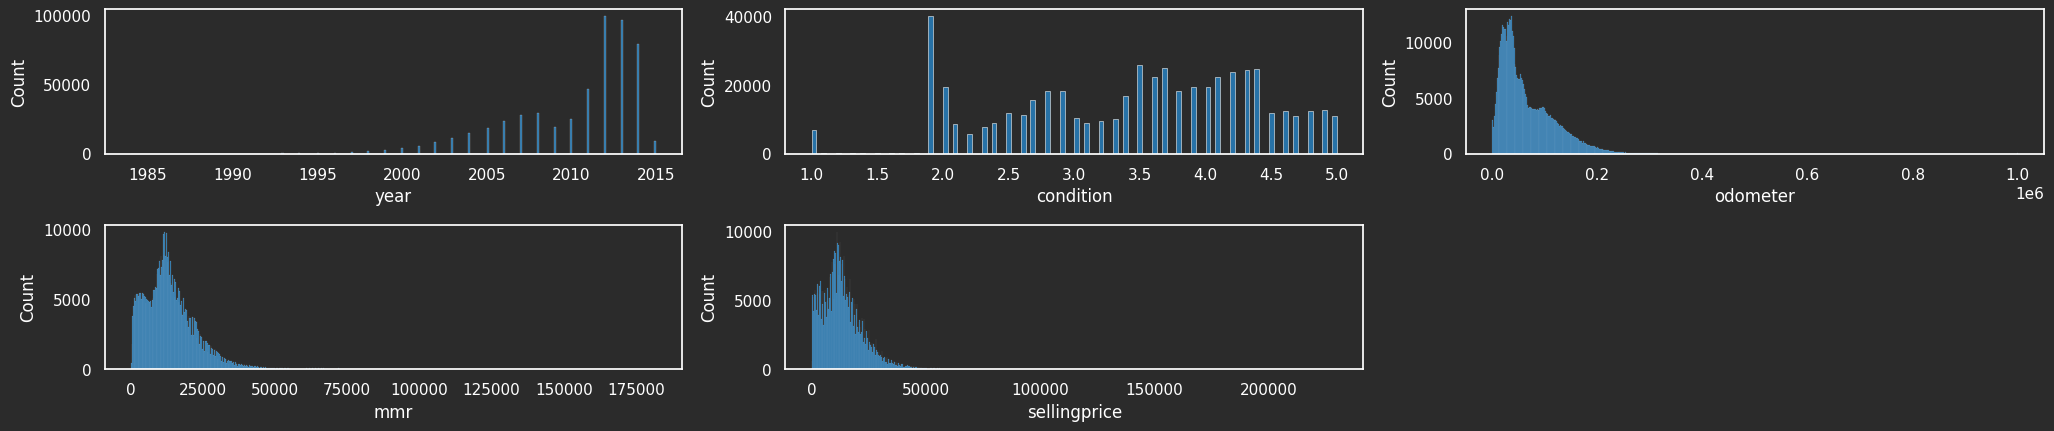

In [26]:
nums = dfcar.select_dtypes(exclude=['object', 'datetime'])

for i, column in enumerate(nums.columns, 1):
    print(f'\n{column}')
    print(f'skewness: {skew(nums[column])}')

    plt.subplot(4, 3, i)
    sns.histplot(nums[column]) #or displot
    plt.tight_layout()

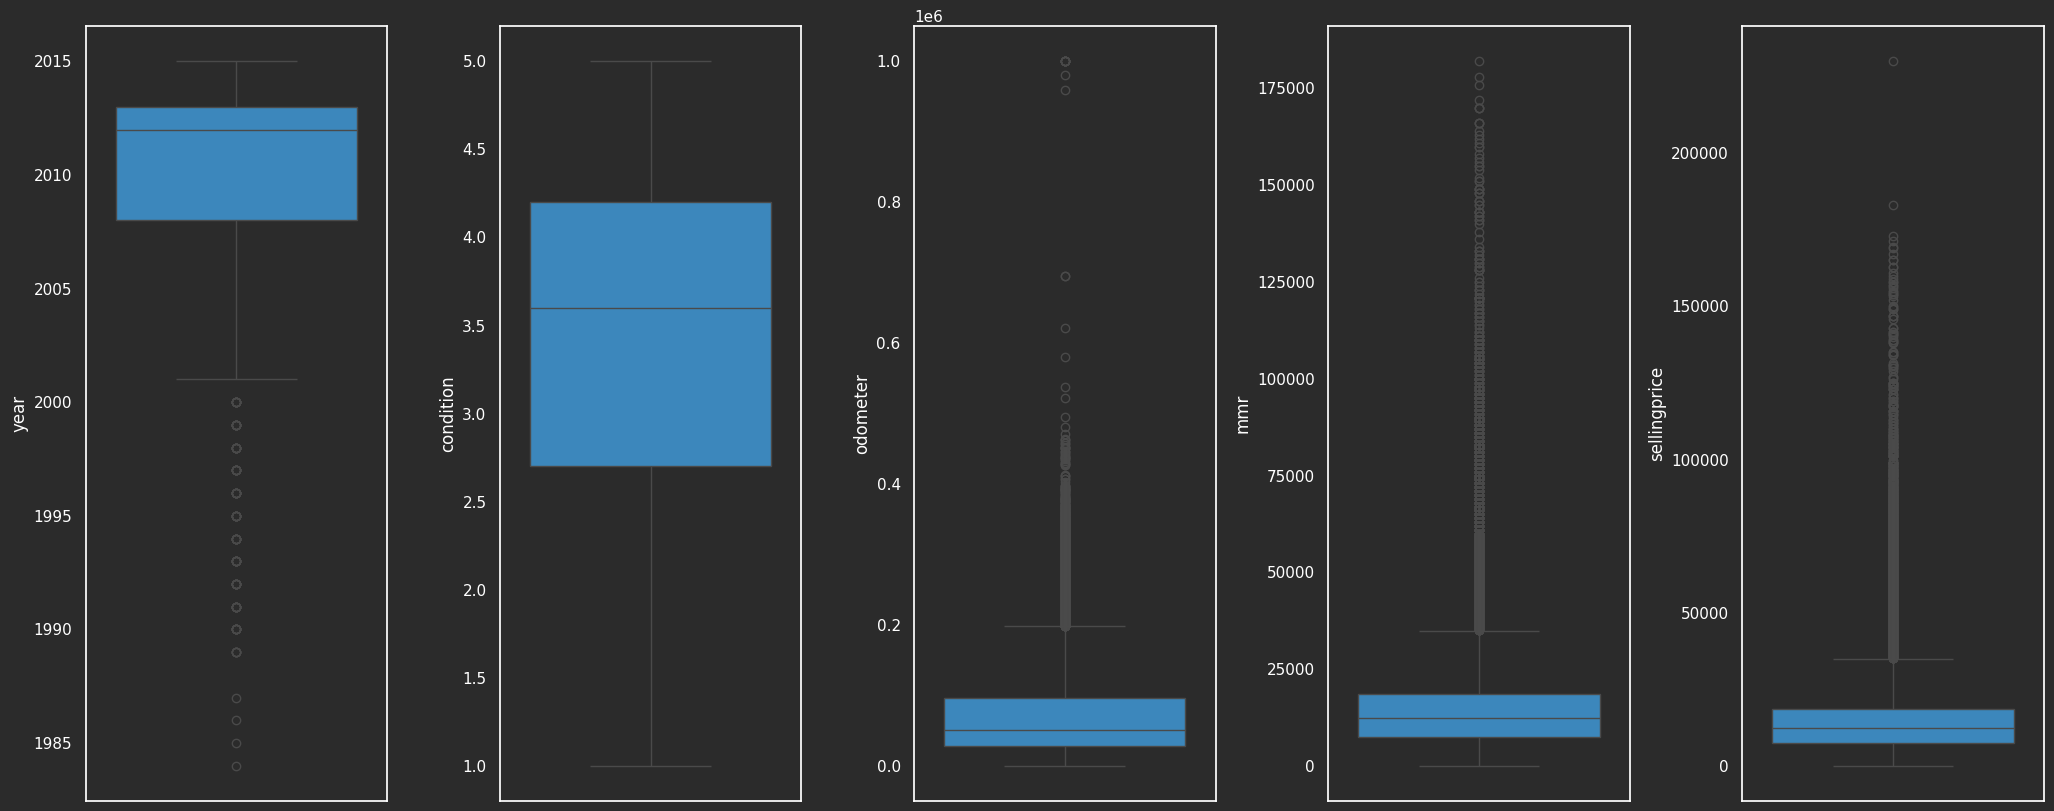

In [27]:
for i, column in enumerate(nums.columns, 1):
    plt.subplot(1, len(nums.columns), i)
    sns.boxplot(y=nums[column])
    plt.tight_layout()

In [28]:
def outlier_del(df, column, mode):
    q1 = df.iloc[:,column].quantile(0.25)
    q3 = df.iloc[:,column].quantile(0.75)
    iqr = q3-q1
    lower_tail = q1 - (1.5 * iqr)
    upper_tail = q3 + (1.5 * iqr)
    nama_kolom = df.columns[column]
    jumlah_outliers = df[(df.iloc[:,column] <= lower_tail)|(df.iloc[:,column] >= upper_tail)].iloc[:,column].count()
    total_row = df.iloc[:,column].count()
    persentase_outliers = round(((jumlah_outliers/total_row)*100),2)
    if mode == 'summary': # Summary of the outliers
        return print('Total Outliers from ', nama_kolom, ' column :', jumlah_outliers, ' and the percentage of the outliers:', persentase_outliers, '%')
    elif mode == 'df': # Delete Outliers
        return df[(df.iloc[:,column] >= lower_tail)&(df.iloc[:,column] <= upper_tail)]
    else :
        return print('Check the input mode')

In [29]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 528474 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          528474 non-null  int64         
 1   make          528474 non-null  object        
 2   model         528474 non-null  object        
 3   trim          528474 non-null  object        
 4   body          528474 non-null  object        
 5   transmission  528474 non-null  object        
 6   vin           528474 non-null  object        
 7   state         528474 non-null  object        
 8   condition     528474 non-null  float64       
 9   odometer      528474 non-null  float64       
 10  color         528474 non-null  object        
 11  interior      528474 non-null  object        
 12  seller        528474 non-null  object        
 13  mmr           528474 non-null  int64         
 14  sellingprice  528474 non-null  int64         
 15  saledate      528

In [30]:
# Outliers checking for each column
column = [9, 13, 14]

for i in range(0, len(column)):
    outlier_del(dfcar, column[i], 'summary')

Total Outliers from  odometer  column : 10782  and the percentage of the outliers: 2.04 %
Total Outliers from  mmr  column : 15948  and the percentage of the outliers: 3.02 %
Total Outliers from  sellingprice  column : 15731  and the percentage of the outliers: 2.98 %


In [31]:
# Deleting outliers
for i in range(0, len(column)):
    dfcar = dfcar[dfcar.index.isin(outlier_del(dfcar, column[i], 'df').reset_index()['index'])]

In [32]:
dfcar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497511 entries, 0 to 558810
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          497511 non-null  int64         
 1   make          497511 non-null  object        
 2   model         497511 non-null  object        
 3   trim          497511 non-null  object        
 4   body          497511 non-null  object        
 5   transmission  497511 non-null  object        
 6   vin           497511 non-null  object        
 7   state         497511 non-null  object        
 8   condition     497511 non-null  float64       
 9   odometer      497511 non-null  float64       
 10  color         497511 non-null  object        
 11  interior      497511 non-null  object        
 12  seller        497511 non-null  object        
 13  mmr           497511 non-null  int64         
 14  sellingprice  497511 non-null  int64         
 15  saledate      497

In [33]:
df_clean = dfcar.copy()

### 4. Feature Extraction

#### *4.1 Body Simplified*

In [34]:
print(df_clean['body'].unique())

['SUV' 'SEDAN' 'CONVERTIBLE' 'COUPE' 'WAGON' 'HATCHBACK' 'CREW CAB'
 'G COUPE' 'G SEDAN' 'ELANTRA COUPE' 'GENESIS COUPE' 'MINIVAN' 'VAN'
 'DOUBLE CAB' 'CREWMAX CAB' 'ACCESS CAB' 'KING CAB' 'SUPERCREW'
 'CTS COUPE' 'EXTENDED CAB' 'E-SERIES VAN' 'SUPERCAB' 'REGULAR CAB'
 'G CONVERTIBLE' 'KOUP' 'QUAD CAB' 'G37 CONVERTIBLE' 'CLUB CAB' 'XTRACAB'
 'CTS WAGON' 'CTS-V COUPE' 'G37 COUPE' 'MEGA CAB' 'CAB PLUS 4' 'Q60 COUPE'
 'Q60 CONVERTIBLE' 'BEETLE CONVERTIBLE' 'TSX SPORT WAGON'
 'PROMASTER CARGO VAN' 'CAB PLUS' 'RAM VAN' 'TRANSIT VAN' 'REGULAR-CAB']


Above you can find the unique values in the "body" column. We see that there are several values which are similar, therefore string manipulation will be carried out in the body column to uniform the strings that has same references.

In [35]:
def category_body(x):
    if 'SUV' in x:
        return 'SUV'
    elif 'SEDAN' in x:
        return 'Sedan'
    elif 'CONVERTIBLE' in x:
         return 'Convertible'
    elif 'COUPE' in x:
        return 'Coupe'
    elif 'KOUP' in x:
        return 'Coupe'
    elif 'WAGON' in x:
        return 'Wagon'
    elif 'HATCHBACK' in x:
        return 'Hatchback'
    elif 'CAB' in x:
        return 'CAB'
    elif 'SUPERCREW' in x:
        return 'CAB'
    elif 'VAN' in x:
        return 'VAN'
    else:
        return "other"

df_clean['body_simple'] = df_clean.apply(lambda x: category_body(x.body), axis=1)

#### *4.2 Brand*

In [36]:
print(df_clean['make'].unique())

['KIA' 'BMW' 'VOLVO' 'NISSAN' 'CHEVROLET' 'AUDI' 'FORD' 'BUICK' 'ACURA'
 'HYUNDAI' 'CADILLAC' 'INFINITI' 'LEXUS' 'MITSUBISHI' 'MERCEDES-BENZ'
 'JEEP' 'MAZDA' 'MINI' 'LINCOLN' 'JAGUAR' 'VOLKSWAGEN' 'TOYOTA' 'SUBARU'
 'SCION' 'DODGE' 'FIAT' 'CHRYSLER' 'HONDA' 'GMC' 'RAM' 'SMART'
 'LAND ROVER' 'PONTIAC' 'SATURN' 'MERCURY' 'HUMMER' 'LANDROVER' 'MERCEDES'
 'PORSCHE' 'SAAB' 'SUZUKI' 'OLDSMOBILE' 'GEO' 'MASERATI' 'ISUZU' 'FORD TK'
 'PLYMOUTH' 'FORD TRUCK' 'DOT' 'VW' 'GMC TRUCK' 'MERCEDES-B' 'DAEWOO']


Similarly, above you can find the unique values in the
"make" column. We observed that there are several values that are the same brand but written differently like we just saw in "body" column, therefore we will manipulate the data to uniform them.


In [37]:
def body(x):
    if 'CHEV TRUCK' in str(x):
        return 'CHEVROLET'
    elif 'DODGE' in str(x):
        return 'DODGE'
    elif 'FORD' in str(x):
         return 'FORD'
    elif 'GMC TRUCK' in str(x):
         return 'GMC'
    elif 'HYUNDAI' in str(x):
         return 'HYUNDAI'
    elif 'LANDROVER' in str(x):
         return 'LAND ROVER'
    elif 'MERCEDES' in str(x):
         return 'MERCEDES-BENZ'
    elif 'MERCEDES-B' in str(x):
         return 'MERCEDES-BENZ'
    elif 'VW' in str(x):
         return 'VOLKSWAGEN'
    else:
        return str(x)

df_clean['brand'] = df_clean.apply(lambda x: body(x.make), axis=1)

#### *4.3 Made In*



We grouped each brand depending on the company's country of origin.

In [38]:
China = ['SMART']
Germany = ['AUDI', 'BMW', 'MERCEDES-BENZ', 'PORSCHE', 'VOLKSWAGEN']
Italy = ['FERRARI', 'FIAT', 'LAMBORGHINI', 'MASERATI']
Japan = ['ACURA', 'HONDA', 'INFINITI', 'ISUZU', 'LEXUS', 'MAZDA', 'MITSUBISHI', 'NISSAN', 'SUBARU', 'SUZUKI', 'TOYOTA']
South_Korea = ['DAEWOO', 'HYUNDAI', 'KIA']
Sweden = ['SAAB', 'VOLVO']
US = ['AIRSTREAM', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER', 'DODGE', 'FISKER', 'FORD', 'GEO', 'GMC', 'HUMMER', 'JEEP', 'LINCOLN', 'MERCURY', 'OLDSMOBILE', 'PONTIAC', 'PLYMOUTH', 'RAM', 'SATURN', 'SCION', 'DOT' ]
UK = ['ASTON MARTIN', 'BENTLEY', 'JAGUAR', 'LAND ROVER', 'LOTUS', 'MINI', 'ROLLS-ROYCE', 'TESLA']

def made_in(x):
    if str(x) in China:
        return 'CHN'
    elif str(x) in Germany:
        return 'DEU'
    elif str(x) in Italy:
        return 'ITA'
    elif str(x) in Japan:
        return 'JPN'
    elif str(x) in South_Korea:
        return 'KOR'
    elif str(x) in Sweden:
        return 'SWE'
    elif str(x) in US:
        return 'USA'
    elif str(x) in UK:
        return 'GBR'
    else:
        return "other"

df_clean['made_in'] = df_clean.apply(lambda x: made_in(x.brand), axis=1)

#### *4.4 Time Extraction*

From the previously formatted "saledate" column, new time related information will be extracted into several new pieces of information.

##### A. Is Weekend

In [39]:
## 'day_of_week' Column
df_clean['day_of_week'] = df_clean['saledate'].dt.day_name().str[:3]

## 'is_weekend' Column
weekday = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
weekend = ['Sat', 'Sun']

def is_weekend(x):
    if str(x) in weekday:
        return 0
    elif str(x) in weekend:
        return 1
    else:
        return "other"

df_clean['is_weekend'] = df_clean.apply(lambda x: is_weekend(x.day_of_week), axis=1)

##### B. Hour Only

In [40]:
## 'hour_only' Column
df_clean['hour_only'] = df_clean['saledate'].dt.hour

##### C. Month and Year

In [41]:
## 'month_year' Column
df_clean['month_year'] = df_clean.saledate.dt.strftime('%b-%y')

##### D. Sale Date

In [42]:
## 'sale_date' Column
df_clean['sale_date'] = df_clean['saledate'].dt.date
df_clean['sale_date'] = pd.to_datetime(df_clean['sale_date'], format = '%Y-%m-%d')

#### *4.5 Car Age*

We created a new "car_age" column, based on the difference between the year of production of the car and the year of sale.

In [43]:
## 'sale_year' column
df_clean['sale_year'] = df_clean['saledate'].dt.year
df_clean['car_age'] = df_clean['sale_year'] - df_clean['year']

In [44]:
# Check for unlogical rows
df_clean[df_clean['car_age'] < 0]

year      make    model     trim   body transmission  \
0      2015       KIA  Sorento       LX    SUV    Automatic   
1      2015       KIA  Sorento       LX    SUV    Automatic   
5      2015    NISSAN   Altima    2.5 S  SEDAN    Automatic   
11     2015       KIA   Optima       LX  SEDAN    Automatic   
13     2015       KIA  Sorento       LX    SUV    Automatic   
...     ...       ...      ...      ...    ...          ...   
68986  2015   HYUNDAI  Elantra       SE  SEDAN    Automatic   
69268  2015    NISSAN   Altima    2.5 S  SEDAN    Automatic   
70515  2015  CHRYSLER      200  LIMITED  SEDAN    Automatic   
73093  2015      FORD   Fusion       SE  SEDAN    Automatic   
73094  2015   HYUNDAI   Sonata       SE  SEDAN    Automatic   

                     vin state  condition  odometer   color interior  \
0      5xyktca69fg566472    CA        5.0   16639.0   White    Black   
1      5xyktca69fg561319    CA        5.0    9393.0   White    Beige   
5      1n4al3ap1fn326013    CA        1.0    5554.0    Gray    Black   
11     5xxgm4a73fg353538    CA        4.8    2034.0     Red      Tan   
13     5xyktca66fg561407    CA        5.0   14634.0  Silver    Black   
...                  ...   ...        ...       ...     ...      ...   
68986  5npdh4ae9fh574412    IN        4.0    7661.0    Gray    Beige   
69268  1n4al3ap5fn318335    PA        1.0    9399.0     Red    Black   
70515  1c3cccab8fn578112    IN        2.0      73.0    Gray      Tan   
73093  3fa6p0h78fr170788    TX        5.0    3427.0   White    Black   
73094  5npe24af4fh038174    CA        1.0    9622.0   Black        —   

                                                  seller    mmr  sellingprice  \
0                                Kia Motors America, Inc  20500         21500   
1                                Kia Motors America, Inc  20800         21500   
5      Enterprise Vehicle Exchange / Tra / Rental / T...  15350         10900   
11                                    Kia Motors Finance  15150         17700   
13                               Kia Motors America, Inc  20600         21500   
...                                                  ...    ...           ...   
68986  Enterprise Vehicle Exchange / Tra / Rental / T...  13850          9200   
69268                     Enterprise Veh Exchange/Rental  14950          3600   
70515  Enterprise Vehicle Exchange / Tra / Rental / T...  16050          6600   
73093                                    Rlb Investments  13700         16300   
73094  Enterprise Vehicle Exchange / Tra / Rental / T...  15450          8900   

                 saledate body_simple     brand made_in day_of_week  \
0     2014-12-16 12:30:00         SUV       KIA     KOR         Tue   
1     2014-12-16 12:30:00         SUV       KIA     KOR         Tue   
5     2014-12-30 12:00:00       Sedan    NISSAN     JPN         Tue   
11    2014-12-16 12:00:00       Sedan       KIA     KOR         Tue   
13    2014-12-16 12:30:00         SUV       KIA     KOR         Tue   
...                   ...         ...       ...     ...         ...   
68986 2014-12-31 12:59:00       Sedan   HYUNDAI     KOR         Wed   
69268 2014-12-30 10:45:00       Sedan    NISSAN     JPN         Tue   
70515 2014-12-31 12:59:00       Sedan  CHRYSLER     USA         Wed   
73093 2014-12-31 10:20:00       Sedan      FORD     USA         Wed   
73094 2014-12-31 15:05:00       Sedan   HYUNDAI     KOR         Wed   

       is_weekend  hour_only month_year  sale_date  sale_year  car_age  
0               0         12     Dec-14 2014-12-16       2014       -1  
1               0         12     Dec-14 2014-12-16       2014       -1  
5               0         12     Dec-14 2014-12-30       2014       -1  
11              0         12     Dec-14 2014-12-16       2014       -1  
13              0         12     Dec-14 2014-12-16       2014       -1  
...           ...        ...        ...        ...        ...      ...  
68986           0         12     Dec-14 2014-12-

Since age should be a positive value, we deleted any row which has negative car_age values in it.

In [45]:
df_clean = df_clean[df_clean['car_age'] >= 0]

#### *4.6 Is Sold Below MMR*

We decided to add "is_sold_below_mmr" feature to find out whether the auction price matches the market price based on MMR which is very useful to compare prices easily.

In [46]:
# 'is_sold_below_mmr' column (1=Yes, 0=No)
df_clean['is_sold_below_mmr'] = df_clean.apply(lambda x: 1 if x.sellingprice < x.mmr else 0, axis=1)

#### *4.7 Longitude and Latitude*

We imported a new dataset to get the information about longitude and latitude coordinates of cities.

In [47]:
state_coordinate = pd.read_csv('/content/drive/My Drive/ml-project/data/statelatlong.csv')
state_coordinate.State.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

After importing the dataset, the list of states in the main dataset is checked.



In [48]:
df_clean.state.sort_values().unique()

array(['AB', 'AL', 'AZ', 'CA', 'CO', 'FL', 'GA', 'HI', 'IL', 'IN', 'LA',
       'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'NC', 'NE', 'NJ', 'NM', 'NS',
       'NV', 'NY', 'OH', 'OK', 'ON', 'OR', 'PA', 'PR', 'QC', 'SC', 'TN',
       'TX', 'UT', 'VA', 'WA', 'WI'], dtype=object)

Since there are some states that do not have the longitude and latitude information, we have done some manual manipulation.

In [49]:
state_coor = pd.DataFrame({'State': ['AB', 'ON', 'PR', 'QC'] ,
                           'Latitude': [53.9333, 51.2538, 18.2208, 46.8131],
                           'Longitude': [-116.5765, -85.3232, -66.5901, -71.2075],
                           'City':['Alberta', 'Ontario', 'Puerto Rico', 'Quebec']})

In [50]:
#state_coordinate = state_coordinate.append(state_coor, ignore_index=True)
#state_coordinate.rename({'State':'state', 'Latitude':'latitude', 'Longitude':'longitude'}, axis=1, inplace=True)

state_coordinate = pd.concat([state_coordinate, state_coor], ignore_index=True)
state_coordinate.rename(columns={'State': 'state', 'Latitude': 'latitude', 'Longitude': 'longitude'}, inplace=True)

As a next step, we merged two datasets.

In [51]:
# Merge
df_clean = df_clean.merge(state_coordinate[['state', 'latitude', 'longitude']], how='left', on='state')
df_clean.sample(2)

year     make          model trim       body transmission  \
347252  2014    DODGE  Grand Caravan   SE    MINIVAN    Automatic   
405610  2014  HYUNDAI         Accent   GS  HATCHBACK    Automatic   

                      vin state  condition  odometer  color interior  \
347252  2c4rdgbg4er222990    NC        4.2   11224.0  White    Black   
405610  kmhct5ae0eu188011    TX        4.4    6403.0  Brown    Black   

                             seller    mmr  sellingprice            saledate  \
347252         Parkway Ford Lincoln  15250         16500 2015-03-03 01:30:00   
405610  Wells Fargo Dealer Services  11000          9800 2015-05-27 03:00:00   

       body_simple    brand made_in day_of_week  is_weekend  hour_only  \
347252         VAN    DODGE     USA         Tue           0          1   
405610   Hatchback  HYUNDAI     KOR         Wed           0          3   

       month_year  sale_date  sale_year  car_age  is_sold_below_mmr  \
347252     Mar-15 2015-03-03       2015        1                  0   
405610     May-15 2015-05-27       2015        1                  1   

         latitude   longitude  
347252  35.214563  -79.891267  
405610  31.169336 -100.076842

In [52]:
df_clean.head(2)

year   make     model        trim   body transmission                vin  \
0  2014    BMW  3 Series  328I SULEV  SEDAN    Automatic  wba3c1c51ek116351   
1  2015  VOLVO       S60          T5  SEDAN    Automatic  yv1612tb4f1310987   

  state  condition  odometer  color interior  \
0    CA        4.5    1331.0   Gray    Black   
1    CA        4.1   14282.0  White    Black   

                                   seller    mmr  sellingprice  \
0  Financial Services Remarketing (Lease)  31900         30000   
1                 Volvo Na Rep/World Omni  27500         27750   

             saledate body_simple  brand made_in day_of_week  is_weekend  \
0 2015-01-15 04:30:00       Sedan    BMW     DEU         Thu           0   
1 2015-01-29 04:30:00       Sedan  VOLVO     SWE         Thu           0   

   hour_only month_year  sale_date  sale_year  car_age  is_sold_below_mmr  \
0          4     Jan-15 2015-01-15       2015        1                  1   
1          4     Jan-15 2015-01-29       2015        0                  0   

    latitude   longitude  
0  37.271875 -119.270415  
1  37.271875 -119.270415

To make it easier to check dataset, we changed the order of columns in a more logical order of features and dropped unnecessary columns like "body" since we created "body_simple" later.

In [53]:
df_clean = df_clean.drop(['make', 'body', 'saledate'], axis=1)
# New column order
new_order = ['vin', 'year', 'brand', 'body_simple', 'model', 'trim',	'made_in', 'transmission',	'condition',	'color',	'interior', 'car_age', 	'odometer', 'state', 'seller', 'sellingprice', 'mmr', 'is_sold_below_mmr', 'day_of_week',	'is_weekend',	'hour_only',	'month_year',	'sale_date',	'sale_year', 'latitude',	'longitude']

# Reorder DataFrame
df_clean = df_clean[new_order]
df_clean.head(2)

vin  year  brand body_simple     model        trim made_in  \
0  wba3c1c51ek116351  2014    BMW       Sedan  3 Series  328I SULEV     DEU   
1  yv1612tb4f1310987  2015  VOLVO       Sedan       S60          T5     SWE   

  transmission  condition  color interior  car_age  odometer state  \
0    Automatic        4.5   Gray    Black        1    1331.0    CA   
1    Automatic        4.1  White    Black        0   14282.0    CA   

                                   seller  sellingprice    mmr  \
0  Financial Services Remarketing (Lease)         30000  31900   
1                 Volvo Na Rep/World Omni         27750  27500   

   is_sold_below_mmr day_of_week  is_weekend  hour_only month_year  sale_date  \
0                  1         Thu           0          4     Jan-15 2015-01-15   
1                  0         Thu           0          4     Jan-15 2015-01-29   

   sale_year   latitude   longitude  
0       2015  37.271875 -119.270415  
1       2015  37.271875 -119.270415

### 5. Insight and Visualization

#### *5.1 Sale Percentage Based on MMR*

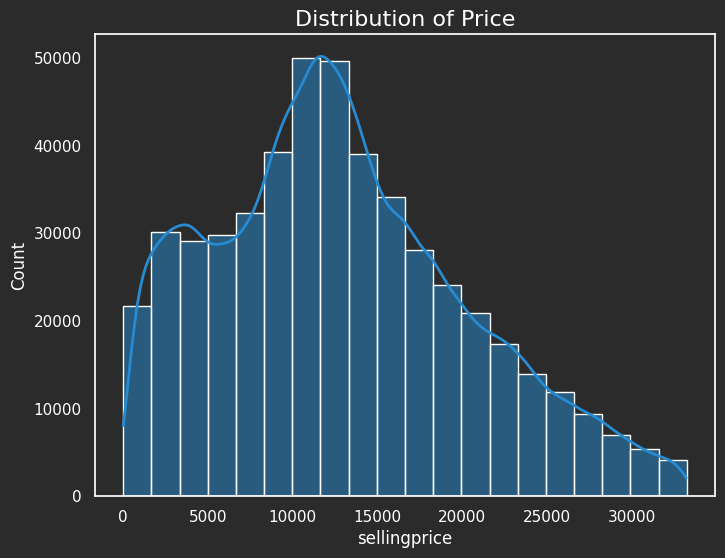

In [54]:
figures = '/content/drive/My Drive/ml-project/figures'

# Price Analysis
plt.figure(figsize=(8, 6))
sns.histplot(data=df_clean['sellingprice'], bins=20, kde=True)
plt.title('Distribution of Price')
plt.savefig(f"{figures}/distribution_price.png")
plt.show()

##### A. Total Transaction

In [55]:
transaction = df_clean.groupby('is_sold_below_mmr').agg({'vin':'count'}).rename({'vin':'total_transaction'}, axis=1)
transaction['percentage'] = round(((transaction/transaction.sum())*100), 2)
transaction

total_transaction  percentage
is_sold_below_mmr                               
0                             240769       48.41
1                             256626       51.59

In [56]:
transaction.reset_index(inplace=True)
persentase_bawah_mmr = transaction[transaction['is_sold_below_mmr']==1].percentage
print(f'\nSale Percentage below MMR: {persentase_bawah_mmr[1]}%\n')


Sale Percentage below MMR: 51.59%



##### B. Car Production Year

In [57]:
year_mmr = df_clean.groupby(['year', 'is_sold_below_mmr']).agg({'vin' : 'count'}).rename({'vin' : 'total_sold'}, axis=1)
year_mmr['percentage'] = round((year_mmr/(year_mmr.groupby(level=0).sum())*100), 2)
year_mmr.reset_index(inplace=True)
year_mmr= year_mmr[year_mmr['is_sold_below_mmr'] == 1]

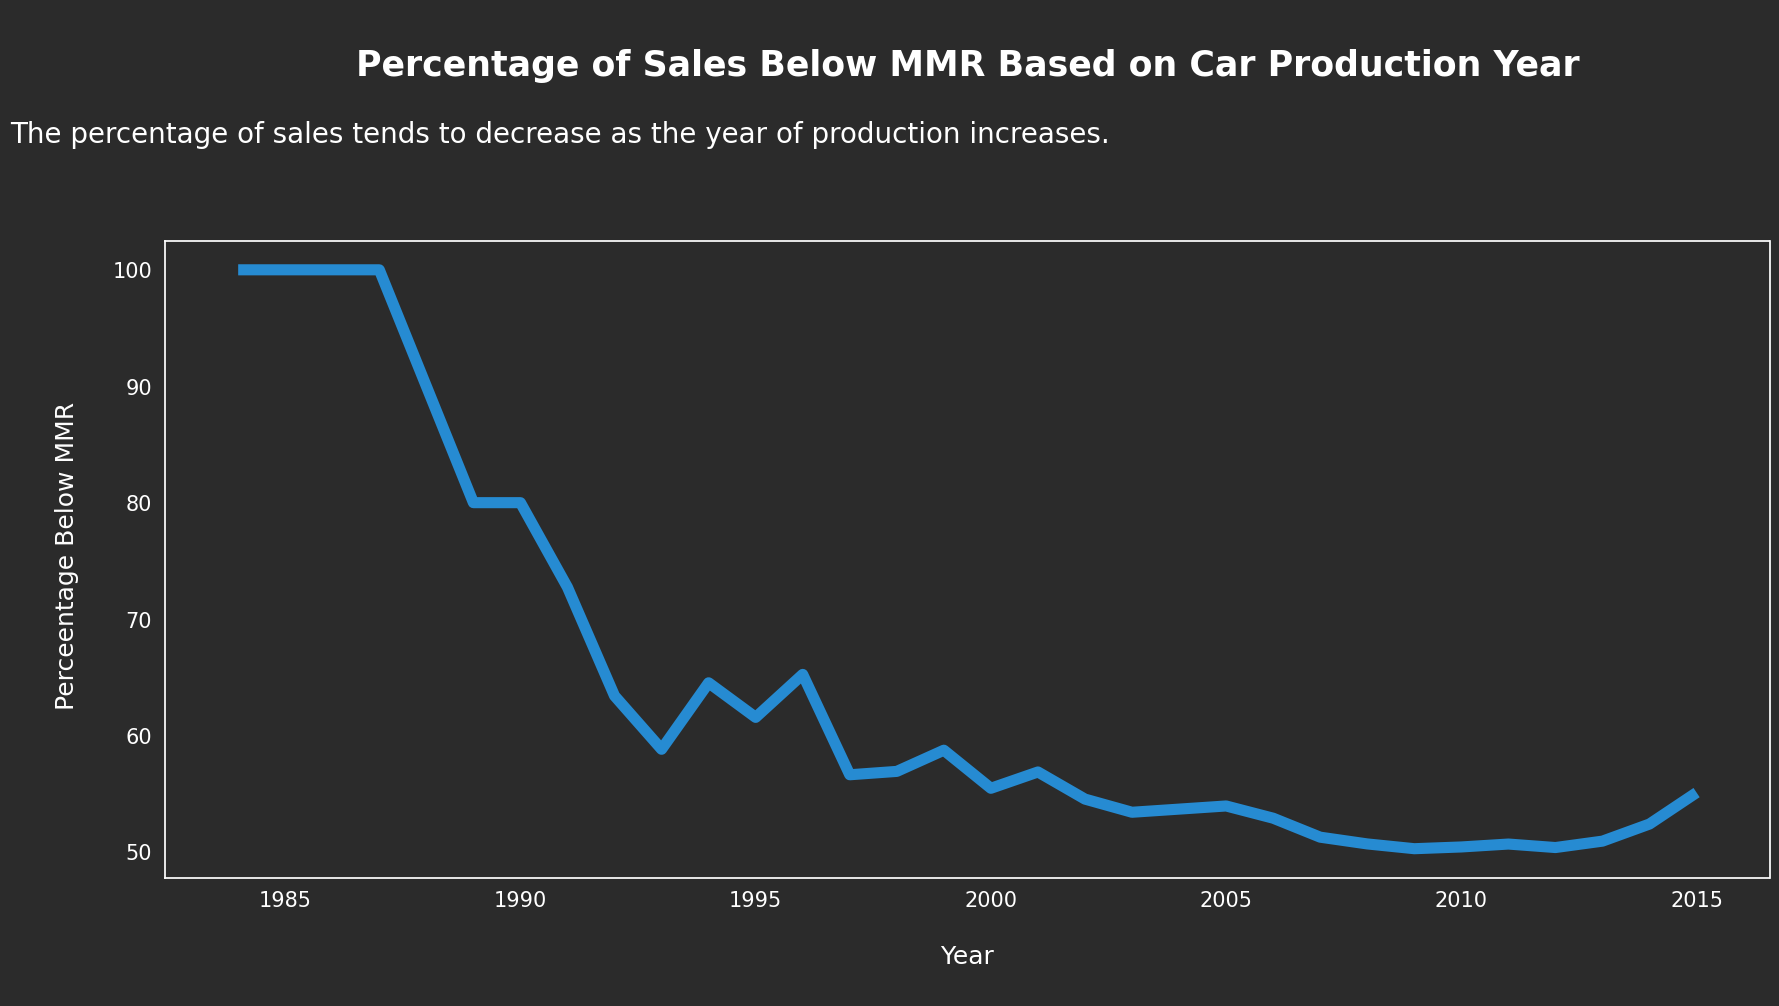

In [58]:
sns.lineplot(year_mmr, x='year', y='percentage', linewidth = 8)
plt.title('\nPercentage of Sales Below MMR Based on Car Production Year', fontsize=25, fontweight='bold', y=1.15, pad=50)
plt.suptitle("The percentage of sales tends to decrease as the year of production increases.", size=20, x=.05, y=1.025, ha='left')
plt.xlabel('\n Year \n', fontsize=18)
plt.ylabel('\n Perceentage Below MMR\n', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig(f"{figures}/sales_below_mmr.png")
plt.show()

#### *5.2 Total Transaction*

##### A. Based on Time - daily

In [59]:
week_hour = df_clean.pivot_table(index='day_of_week',columns='hour_only',values='vin',aggfunc='count')
week_hour = week_hour.reindex(index=['Mon','Tue', 'Wed','Thu', 'Fri', 'Sat', 'Sun'])
week_hour = week_hour.fillna(0)

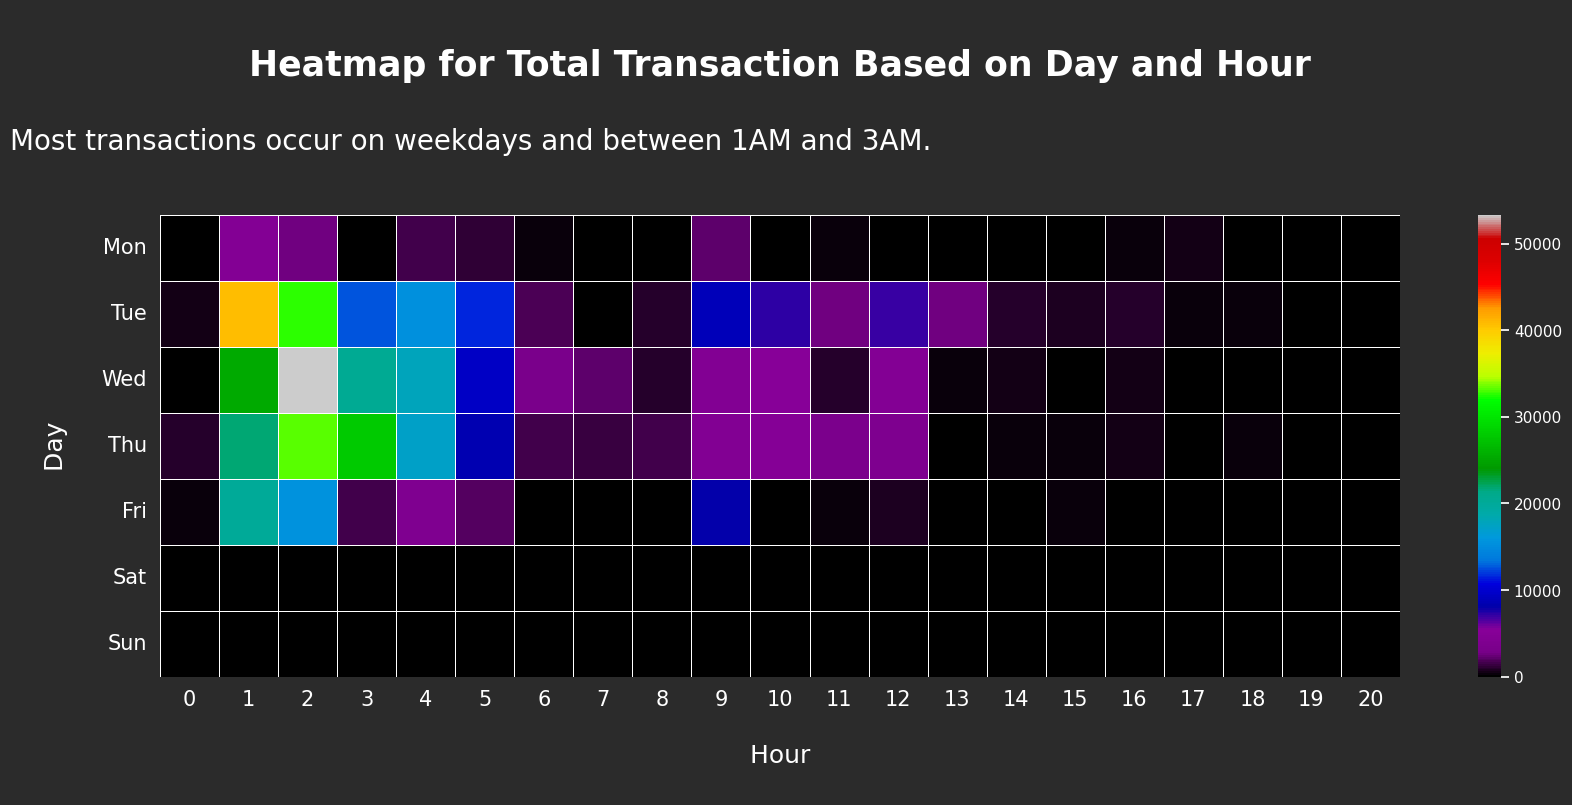

In [60]:
f, ax = plt.subplots(figsize=(20, 6))

sns.heatmap(week_hour, cmap='nipy_spectral', annot=False, fmt="2f", linewidths=.5, ax=ax)
plt.title('\nHeatmap for Total Transaction Based on Day and Hour', fontsize=25, fontweight='bold', y=1.15, pad=50)
plt.suptitle("Most transactions occur on weekdays and between 1AM and 3AM.", size=20, x=.05, y=1.025, ha='left')
plt.xlabel('\n Hour \n', fontsize=18)
plt.ylabel('\n Day \n', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yticks(rotation=0)
plt.savefig(f"{figures}/heatmap_sales_day_hour.png")
plt.show()

##### B. Based on Car Age

In [61]:
transaction_year = df_clean.groupby(['car_age'], as_index=False).vin.count().rename({'vin':'count'}, axis=1)

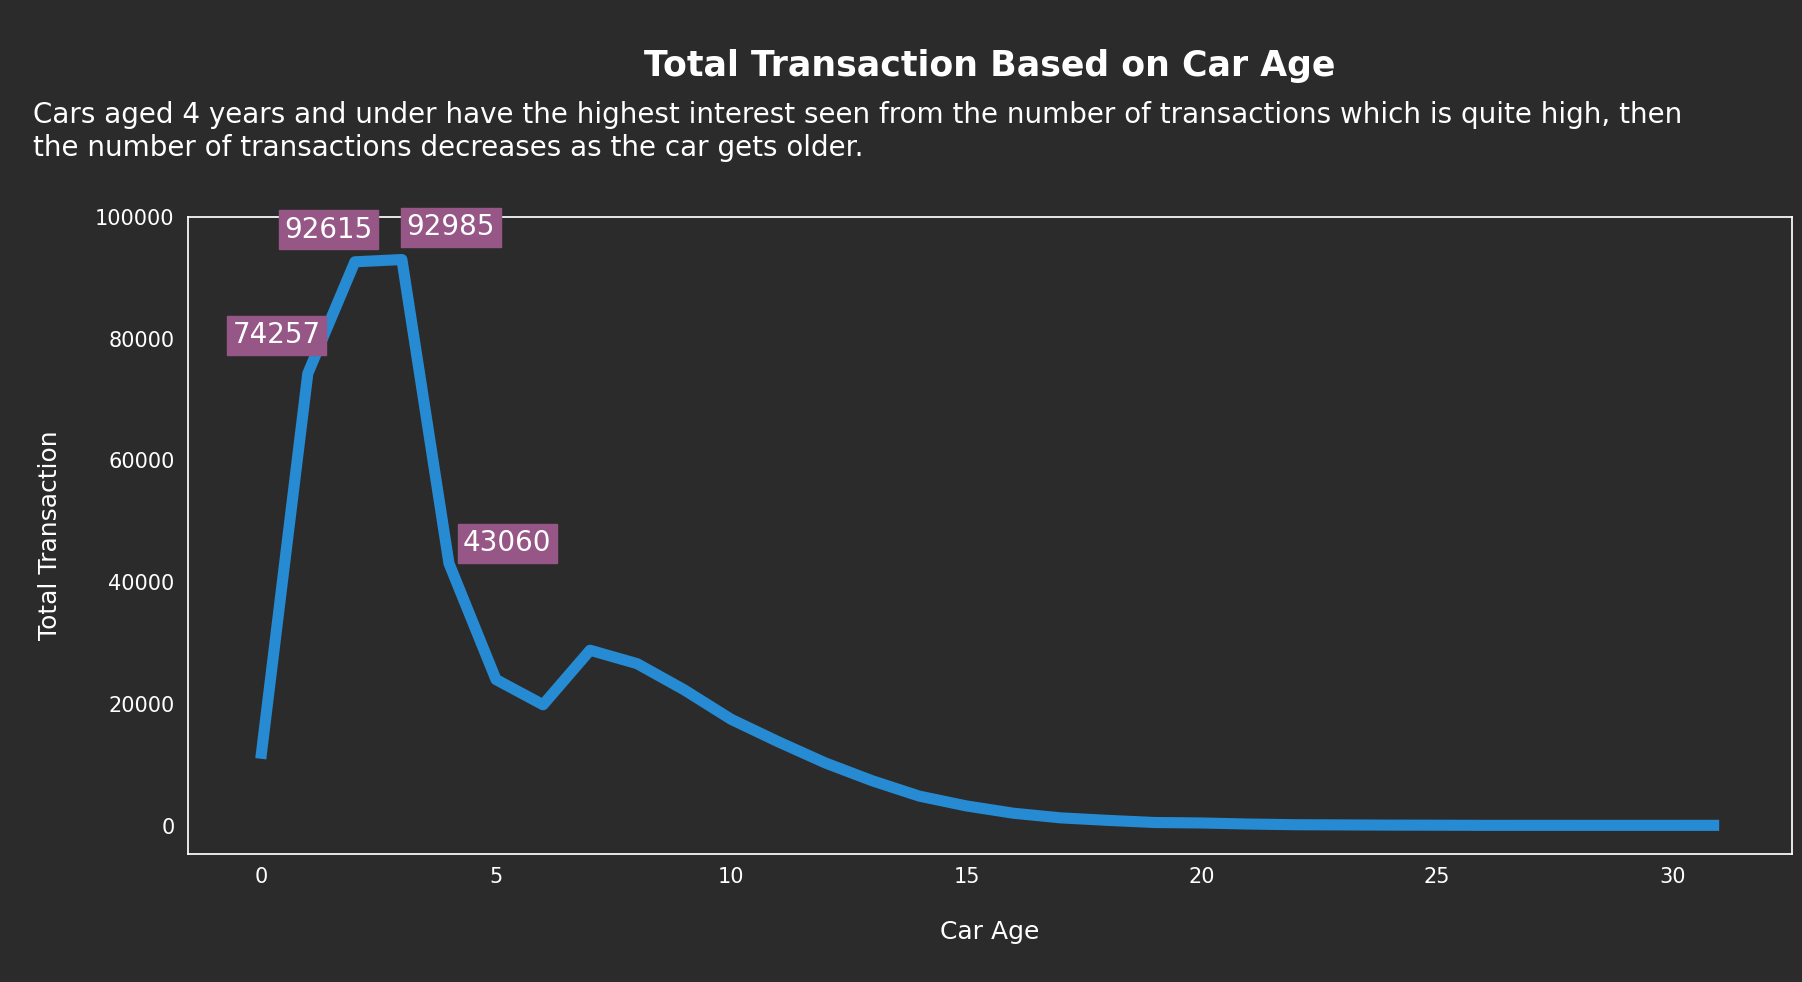

In [62]:
ax = sns.lineplot(transaction_year, x='car_age', y='count', linewidth = 8)
ax.axes.set_title('\nTotal Transaction Based on Car Age\n',fontsize=25, fontweight='bold', y=1.05, pad=50)
ax.figure.suptitle("Cars aged 4 years and under have the highest interest seen from the number of transactions which is quite high, then \nthe number of transactions decreases as the car gets older.\n",
                   size=20, x=0.05, y=1.02, ha='left')

# label points on the plot
#1
plt.text(x = transaction_year[transaction_year['car_age']==1]['car_age']-1.6, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==1]['count']+5000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==1]['count'].values[0]), # data label, formatted to ignore decimals
 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

#2
plt.text(x = transaction_year[transaction_year['car_age']==2]['car_age']-1.5, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==2]['count']+4000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==2]['count'].values[0]), # data label, formatted to ignore decimals
 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

#3
plt.text(x = transaction_year[transaction_year['car_age']==3]['car_age']+0.1, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==3]['count']+4000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==3]['count'].values[0]), # data label, formatted to ignore decimals
                 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

#4
plt.text(x = transaction_year[transaction_year['car_age']==4]['car_age']+0.3, # x-coordinate position of data label
 y = transaction_year[transaction_year['car_age']==4]['count']+2000, # y-coordinate position of data label, adjusted to be 150 below the data point
 s = '{:.0f}'.format(transaction_year[transaction_year['car_age']==4]['count'].values[0]), # data label, formatted to ignore decimals
 color = 'white',  # set colour of line
 fontsize = 20).set_backgroundcolor('#965786')

plt.xlabel('\n Car Age \n', fontsize=18)
plt.ylabel('\n Total Transaction \n', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yticks(rotation=0)
plt.ylim(top=100000)
plt.savefig(f"{figures}/sales_by_age.png")
plt.show()

As we observed from the plot, buyers are more likely to buy cars aged 4 years and under from a demand perspective. On the other hand, from a supply perspective, car owners tend to auction their vehicles despite their age.

We can clearly see that, cars aged 4 years and under have the highest interest as seen from the number of transactions which is quite high and then the number of transactions decreases as the age of the car increases.

The above plot shows an unstable transaction history. We need to remind the fact that the data is the result of scrapping from various resources, so that the monthly transaction history cannot be used as a benchmark.

##### C. Based on Brand

###### I. Best Selling Brand

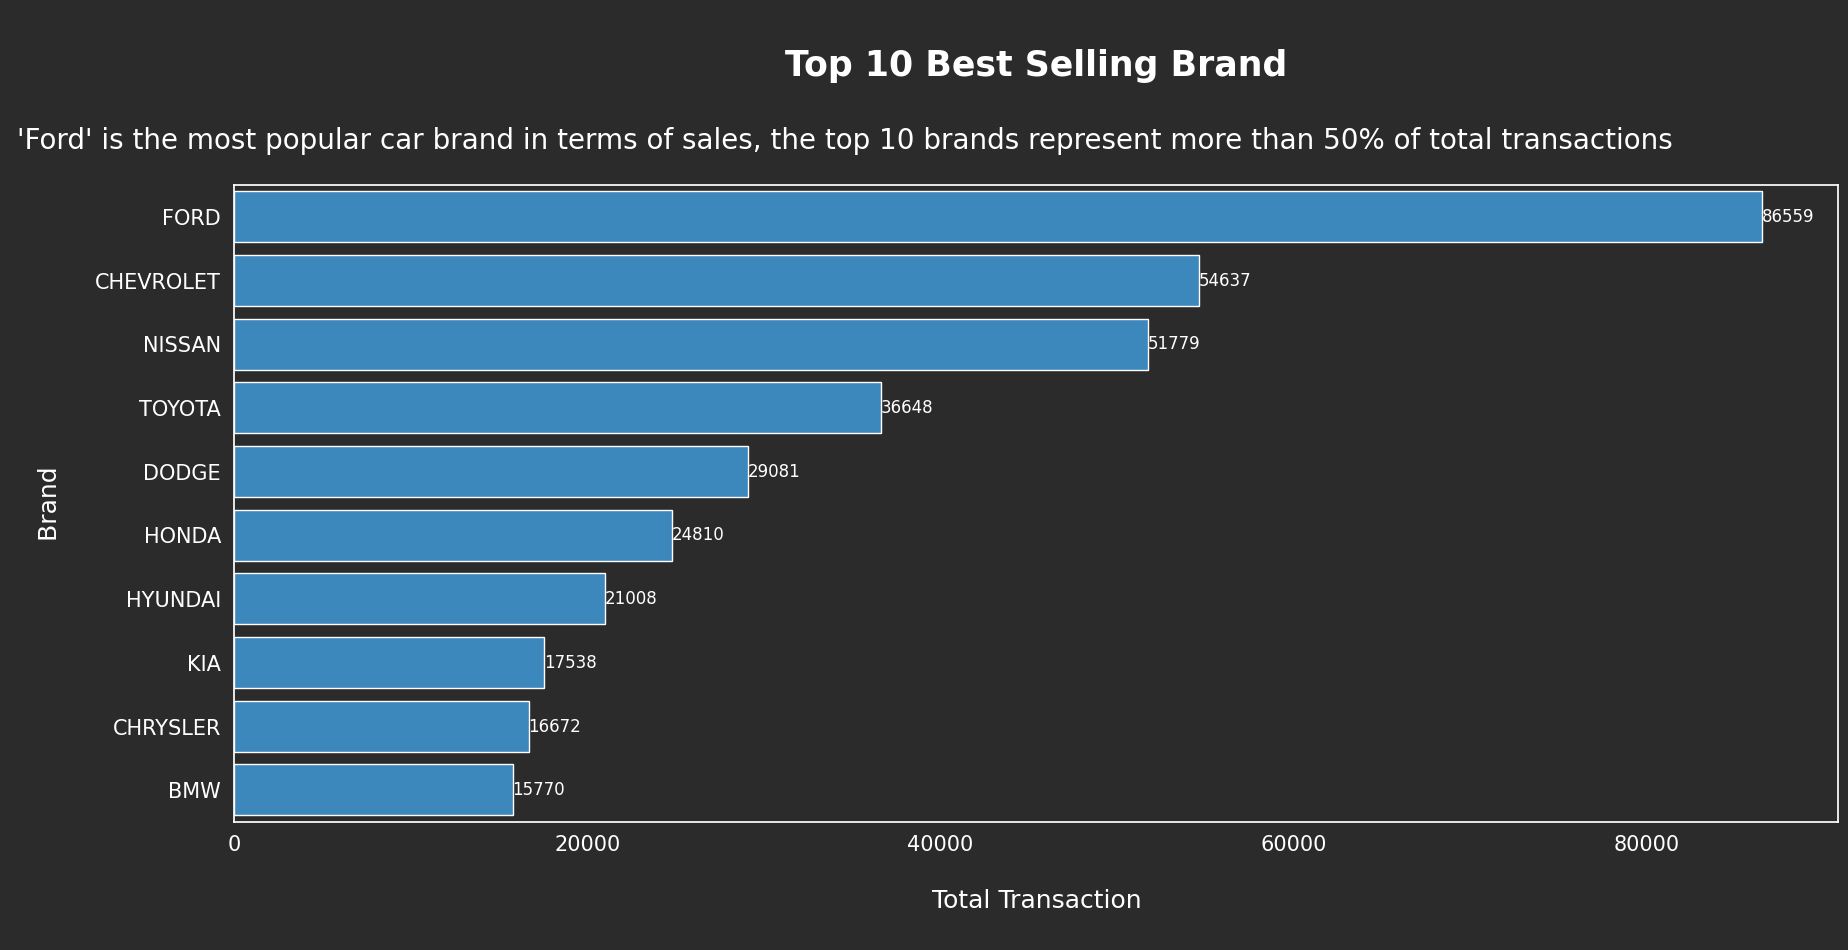

In [63]:
ax = sns.countplot(y=df_clean.brand, order=df_clean.brand.value_counts().iloc[:10].index)

ax.axes.set_title('\nTop 10 Best Selling Brand\n',fontsize=25, fontweight='bold', y=1, pad=50)
ax.figure.suptitle("'Ford' is the most popular car brand in terms of sales, the top 10 brands represent more than 50% of total transactions", size=20, x=.02, y=.95, ha='left')
ax.bar_label(ax.containers[0])

plt.xlabel('\n Total Transaction \n', fontsize=18)
plt.ylabel('\n Brand \n', fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.yticks(rotation=0)
plt.savefig(f"{figures}/top10_brand.png")
plt.show()

##### D. Based on Body Type

In [64]:
import plotly.express as px
import plotly.io as pio

fig = px.histogram(df_clean, y='body_simple',
                   color='body_simple',
                   labels={'body_simple': 'Body'},
                   title='<b> Best Selling Body Type <b>',
                   width=1000,
                   height=450
                  )

# Sorting y
fig.update_yaxes(categoryorder='total ascending')

fig.update_layout(
    paper_bgcolor='#2B2B2B',  # Dark gray background
    plot_bgcolor='#2B2B2B',   # Dark gray plot background
    xaxis_title='Total Transaction',
    yaxis_title='Brand',
    font=dict(color='white'),  # White font color for all text elements
    title=dict(font=dict(size=30), automargin=True, x=0.5, y=0.95),
    margin=dict(
        l=100,
        r=80,
        b=50,
        t=150,
        pad=10
    ),
    xaxis=dict(
        showgrid=False,      # Hide x-axis gridlines
        zeroline=False,      # Hide x-axis zero line
        color='white'        # White color for x-axis labels and title
    ),
    yaxis=dict(
        showgrid=False,      # Hide y-axis gridlines
        zeroline=False,      # Hide y-axis zero line
        color='white'        # White color for y-axis labels and title
    )
)


fig.add_annotation(xref='paper', yref='paper', x=0, y=1.35,
                              text='<br>Sedans and SUVs are drastically more popular than others, in terms of sales. This is also due to the increasing number <br>of brands using these two body types as the basis for the cars they make because of their popularity.',
                              font=dict(family='Arial',
                                        size=16),
                              showarrow=False)

pio.write_image(fig, f"{figures}/best_body_type.png")
fig.show()

To prove our argument that many brands make models based on Sedan and SUV, we will group them together to analyse better.



In [65]:
df_clean.groupby(['brand', 'body_simple'], as_index=False)['model'].nunique().sort_values('model', ascending=False).head(20)

brand body_simple  model
32       CHEVROLET       Sedan     35
59            FORD       Sedan     29
107          LEXUS       Sedan     21
27       CHEVROLET         CAB     18
47           DODGE       Sedan     17
129  MERCEDES-BENZ       Sedan     16
86        INFINITI       Sedan     15
122          MAZDA       Sedan     14
15             BMW       Sedan     14
39        CHRYSLER       Sedan     14
135        MERCURY       Sedan     13
60            FORD         VAN     13
85        INFINITI         SUV     13
208         TOYOTA       Sedan     13
31       CHEVROLET         SUV     12
165        PONTIAC       Sedan     12
25        CADILLAC       Sedan     12
9             AUDI       Sedan     11
80         HYUNDAI       Sedan     11
64             GMC         SUV     11

Above table confirms our thesis about popular body types.

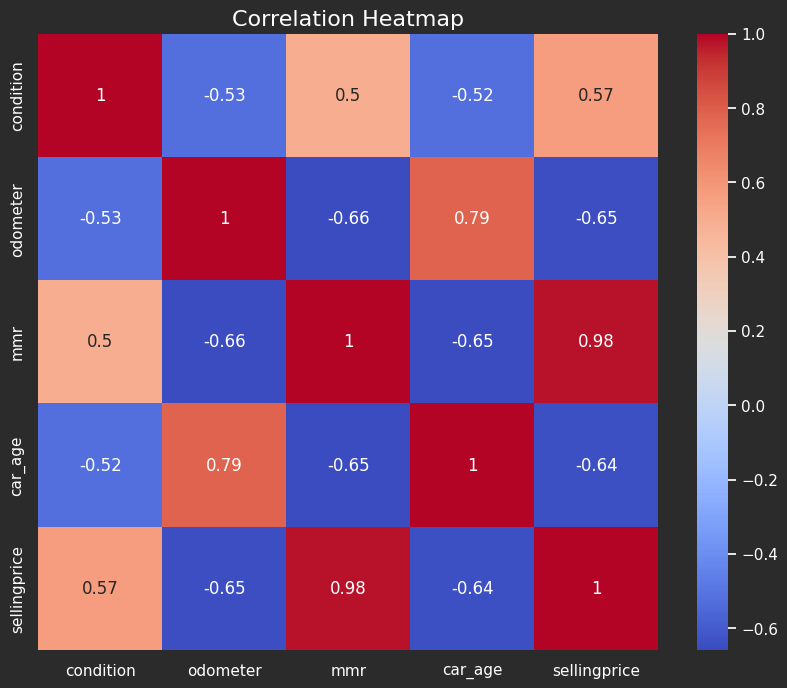

In [66]:
# Distribution of Numerical Features
numerical_columns = ['condition', 'odometer', 'mmr', 'car_age', 'sellingprice']
# Correlation Analysis
correlation_matrix = df_clean[numerical_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig(f"{figures}/corr_numerical_heatmap.png")
plt.show()

Looking at the above numerical features analysis, we see that car_age, odometer, and of course mmr are strong features to predict selling price. So we'll continue with them in our models.

##### E. Based on States

In [67]:
state_sales = df_clean.groupby(['state', 'latitude', 'longitude'], as_index=False)['vin'].count().rename({'vin':'count'}, axis=1)

In [78]:
import plotly.graph_objects as go
import plotly.io as pio

fig = go.Figure(data=go.Scattergeo(
        lon = state_sales['longitude'],
        lat = state_sales['latitude'],
        text = state_sales['state'],
        mode = 'markers',
        marker = dict(
            size = 15,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'speed',
            cmin = 0,
            color = state_sales['count'],
            cmax = state_sales['count'].max(),
            colorbar=dict(
                title=dict(
                    text="Total Transaction",
                    font=dict(color='white')
                ),
                tickfont=dict(color='white')
            )
        )))

fig.update_geos(
    visible=False, resolution=50, scope="north america",
    showcountries=True, countrycolor="Black",
    showsubunits=True, subunitcolor="Blue"
)

annotations = []

annotations.append(dict(xref='paper', yref='paper', x=0.05, y=1.15,
                              xanchor='left', yanchor='bottom',
                              text="<br><b> Total Car Sold based on Where's the Car Come From <b>",
                              font=dict(family='Arial',
                                        size=30,
                                        color='white'),
                              showarrow=False))

annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Most of the auctioned cars come from California and Florida.',
                              font=dict(family='Arial',
                                        size=18,
                                        color='white'),
                              showarrow=False))

fig.update_layout(
    autosize=False,
    width=1000,
    height=700,
    margin=dict(
        l=80,
        r=80,
        b=50,
        t=150,
        pad=10
    ),
    paper_bgcolor='#2B2B2B',  # Dark gray background
    annotations=annotations
)
pio.write_image(fig, f"{figures}/sales_car_states.png")
fig.show()

#### *5.3 Models with a fairly high percentage of sales below MMR*

In [69]:
# Grouping model
model_mmr = df_clean.groupby(['model', 'brand', 'is_sold_below_mmr']).agg({'vin' : 'count'}).rename({'vin' : 'total_sold'}, axis=1)
model_mmr['percentage'] = round((model_mmr/(model_mmr.groupby(level=0).sum())*100), 2)
model_mmr.reset_index(inplace=True)

In [70]:
model_mmr['total_sold'].describe()

count    1509.000000
mean      329.618953
std       831.539694
min         1.000000
25%         9.000000
50%        48.000000
75%       222.000000
max      9793.000000
Name: total_sold, dtype: float64

To determine the criteria for categorizing car models with the greatest potential impact on income, we use the following thresholds:

Percentage below MMR: 50%, Total units sold below MMR: 48 (median)

Percentage below MMR: 75%, Total units sold below MMR: 222 (75th percentile)

In [71]:
# Filtering based on the given criteria
unrecomended_model = model_mmr[((model_mmr['is_sold_below_mmr']==1) & (model_mmr['percentage']> 50) & (model_mmr['total_sold']>=48)) |
                               ((model_mmr['is_sold_below_mmr']==1) & (model_mmr['percentage']> 75) & (model_mmr['total_sold']>=24))].sort_values('total_sold', ascending=False)
unrecomended_model.reset_index(drop='index', inplace=True)
unrecomended_model.head(5)

model   brand  is_sold_below_mmr  total_sold  percentage
0  Altima  NISSAN                  1        9793       52.02
1  Fusion    FORD                  1        6742       53.10
2   F-150    FORD                  1        6503       52.34
3   Camry  TOYOTA                  1        6313       53.72
4  Escape    FORD                  1        5933       51.51

In [72]:
print(f'\nTotal number of models with a fairly high percentage of sales below MMR: {unrecomended_model.model.nunique()}\n\n')


Total number of models with a fairly high percentage of sales below MMR: 245




The following is a list of car models and brands with a fairly high percentage of sales below MMR:

In [73]:
unrecomended_model[['brand', 'model']].sort_values(['brand', 'model']).reset_index(drop='index')
unrecomended_model.groupby('brand', as_index=False).model.count().rename(({'model':'total_model'}), axis=1).sort_values('total_model', ascending=False).head(5)

brand  total_model
7        FORD           28
4   CHEVROLET           27
16      LEXUS           14
6       DODGE           13
33     TOYOTA           11

There are around 245 models that have a fairly high percentage of sales below MMR with Ford and Chevrolet being the largest contributors. These findings can provide information that although these two car brands can be said to have the most interest, it does not rule out the possibility that some of their models are less attractive to customers, resulting in their prices at auction not being too high.



#### *5.4 Seller*

In [74]:
seller_summary = df_clean.groupby(['seller'], as_index=False)[['brand', 'state', 'made_in', 'vin']].nunique().sort_values('vin', ascending=False)
seller_summary

seller  brand  state  made_in    vin
7841              Nissan-Infiniti Lt      2     15        1  19666
4434   Ford Motor Credit Company,Llc     28     20        5  18701
10831          The Hertz Corporation     34     31        8  17903
9938              Santander Consumer     40     18        8  14843
1283                Avis Corporation     27     26        7  12035
...                              ...    ...    ...      ...    ...
8334        Palm Chrysler Jeep Dodge      1      1        1      1
3417    Diamond Buick Gmc Alexandria      1      1        1      1
8330              Palm Canyon Motors      1      1        1      1
3427        Dick Brantmeier Ford Inc      1      1        1      1
12105                 Zygi Auto Corp      1      1        1      1

[12106 rows x 5 columns]

#### *5.5 Brands*

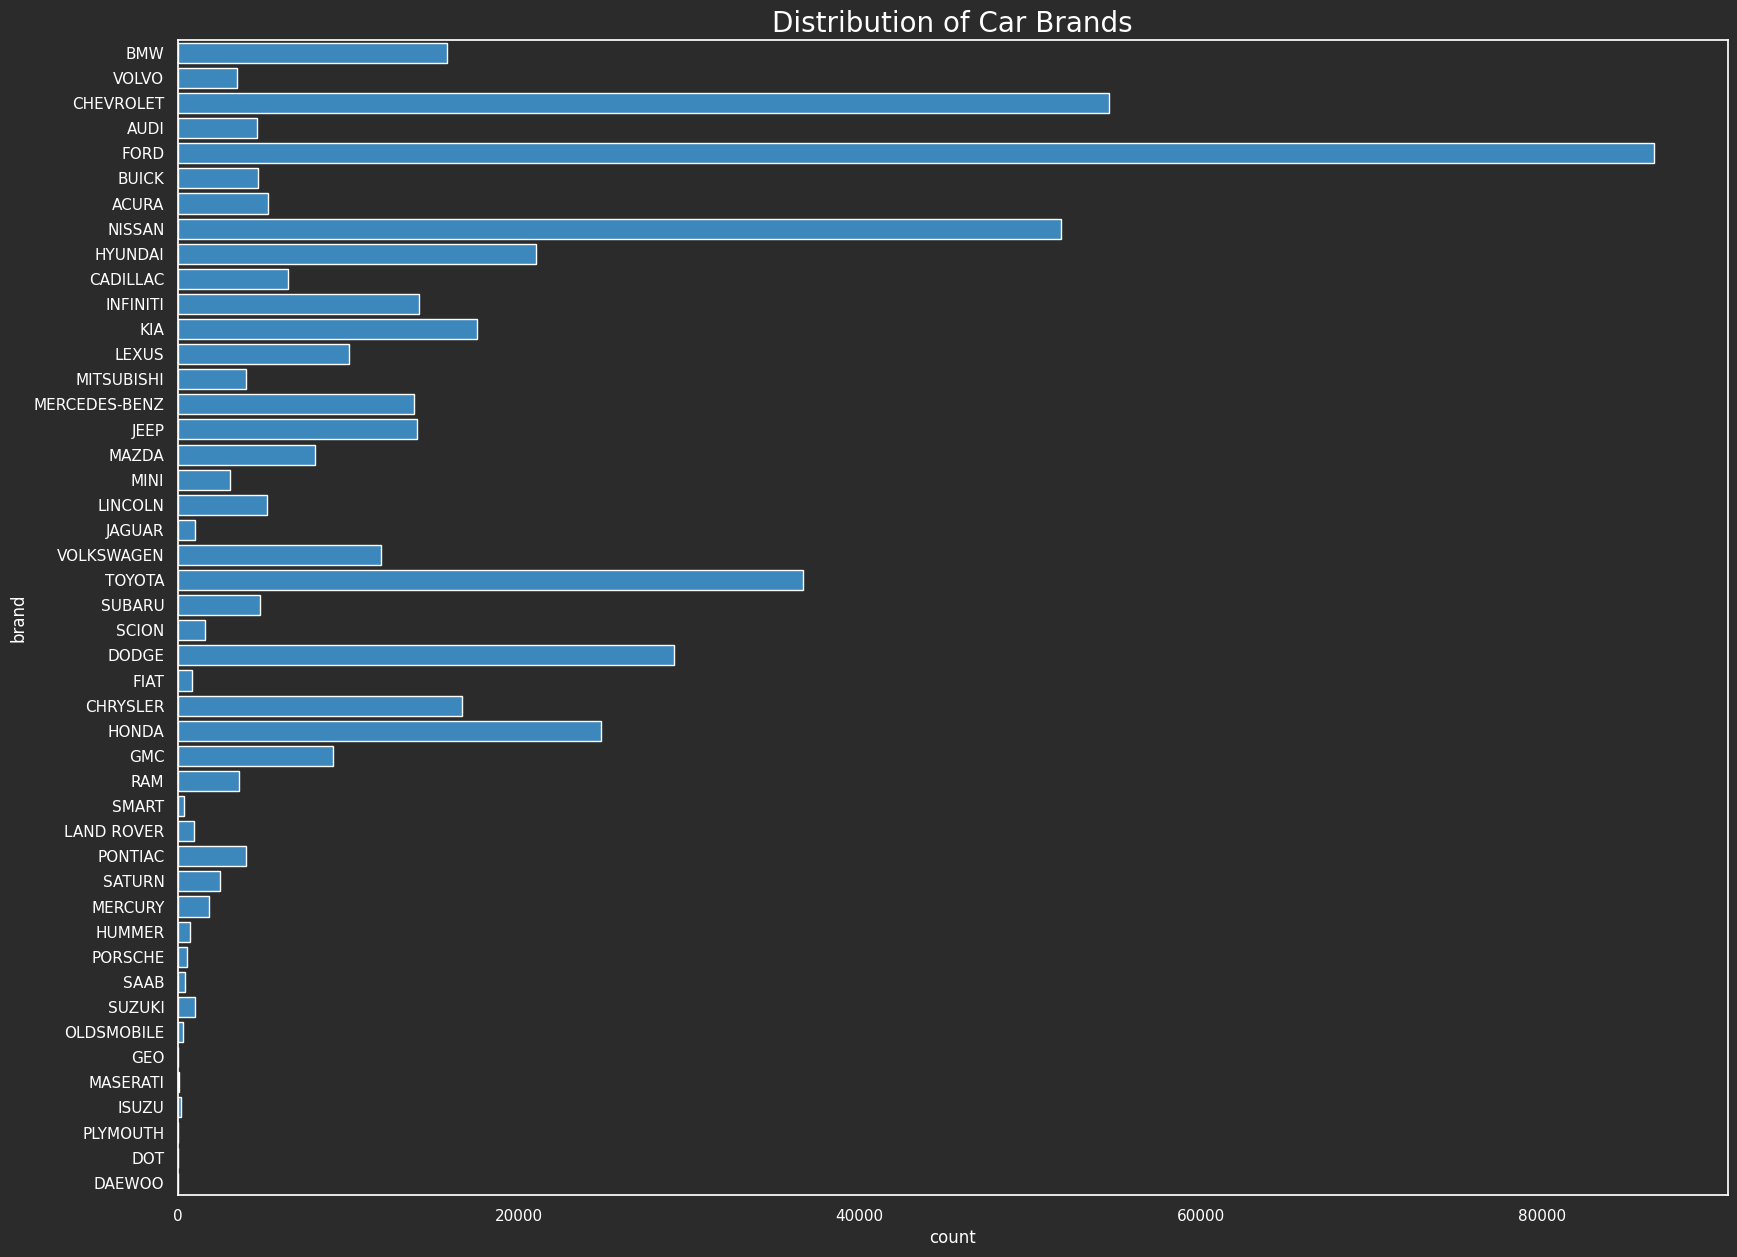

In [75]:
plt.figure(figsize = (20, 15))
sns.countplot(y = df_clean.brand)
plt.title("Distribution of Car Brands", fontsize = 20)
plt.savefig(f"{figures}/distribution_brands.png")
plt.show()

### 6. Conclusion

- Only about 48% of all cars at auction sell at or above the MMR price, and the older the year of production, the more likely a car is to sell below the MMR.

- Based on the history of monthly transactions, unstable results are recorded, and most transactions tend to occur on weekdays early in the morning, this is probably because many sellers are companies that close on weekends. Also online auction closings are quite often done at midnight or early in the morning.

- Sedan and Convertible are the two most popular body types, and Ford, Chevrolet and Nissan are the most popular brands.

- There are around 245 models that have a fairly high percentage of sales below MMR with Ford and Chevrolet being the largest contributors.

In [76]:
df_clean.head(2)

vin  year  brand body_simple     model        trim made_in  \
0  wba3c1c51ek116351  2014    BMW       Sedan  3 Series  328I SULEV     DEU   
1  yv1612tb4f1310987  2015  VOLVO       Sedan       S60          T5     SWE   

  transmission  condition  color interior  car_age  odometer state  \
0    Automatic        4.5   Gray    Black        1    1331.0    CA   
1    Automatic        4.1  White    Black        0   14282.0    CA   

                                   seller  sellingprice    mmr  \
0  Financial Services Remarketing (Lease)         30000  31900   
1                 Volvo Na Rep/World Omni         27750  27500   

   is_sold_below_mmr day_of_week  is_weekend  hour_only month_year  sale_date  \
0                  1         Thu           0          4     Jan-15 2015-01-15   
1                  0         Thu           0          4     Jan-15 2015-01-29   

   sale_year   latitude   longitude  
0       2015  37.271875 -119.270415  
1       2015  37.271875 -119.270415

In [77]:
import os

# Define the path to the data/processed folder
output_folder = '/content/drive/My Drive/ml-project/data'
os.makedirs(output_folder, exist_ok=True)

# Save the DataFrame to a CSV file in the data/processed folder
output_file = os.path.join(output_folder, 'dfcar_processed.csv')
df_clean.to_csv(output_file, index=False)

### References:
https://www.kaggle.com/code/irhammaulanaahmadi/car-auction-data-cleansing-and-insight